# MCMC From Scratch
## Sebastian D. Goodfellow, Ph.D.

In [1]:
# Configure Notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import 3rd party libraries
import numpy as np
import matplotlib.pylab as plt

# 1. Dummy Data Example

## Create Dummy Data

Observed Mean: 9.837250174412025


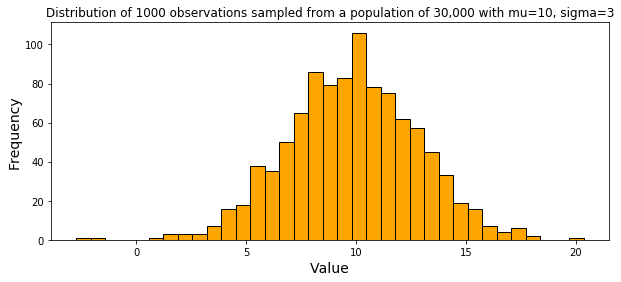

In [12]:
# Create sample population with nodel distribution (mean: 10, std: 3)
population = np.random.normal(10, 3, 30000)

# Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

# Plot Observations
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(observation,bins=35, color='orange', edgecolor='k')
ax.set_xlabel('Value', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3')
print('Observed Mean: {}'.format(observation.mean()))

## Implementation

In [39]:
def transition_model(x):
    """
    The tranistion model defines how to move from sigma_current to sigma_new.
    """
    return [x[0], np.random.normal(x[1], 0.5, (1,))[0]]

In [40]:
def prior(x):
    """
    x[0] = mu, x[1] = sigma (new or current)
    
    Returns 1 for all valid values of sigma. 
    Log(1) = 0, so it does not affect the summation.
    
    Returns 0 for all invalid values of sigma (<=0). 
    Log(0)=-infinity, and Log(negative number) is undefined.
    
    It makes the new sigma infinitely unlikely.
    """
    if x[1] <= 0:
        return 0
    else:
        return 1

In [41]:
def manual_log_likelihood_normal(x, data):
    """
    Computes the likelihood of the data given a sigma (new or current).
    
    x[0] = mu, x[1] = sigma (new or current)
    data = the observation
    """
    return np.sum(-np.log(x[1] * np.sqrt(2 * np.pi)) - 
                  ((data - x[0])**2) / (2 * x[1]**2))

In [42]:
def log_likelihood_normal(x,data):
    """
    Same as manual_log_likelihood_normal(x, data), but using scipy implementation #slow.
    x[0] = mu, x[1] = sigma (new or current)
    data = the observation
    """
    return np.sum(np.log(scipy.stats.norm(x[0], x[1]).pdf(data)))

In [43]:
def acceptance(x, x_new):
    """
    Defines whether to accept or reject the new sample.
    """
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0, 1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number.
        # less likely x_new are less likely to be accepted.
        return (accept < (np.exp(x_new - x)))

In [51]:
def metropolis_hastings(likelihood_computer, prior, transition_model, 
                        param_init, iterations, data, acceptance_rule):
    """
    likelihood_computer(x, data): returns the likelihood that these parameters generated the data.
    transition_model(x): a function that draws a sample from a symmetric distribution and returns it.
    param_init: a starting sample.
    iterations: number of accepted to generated.
    data: the data that we wish to model.
    acceptance_rule(x, x_new): decides whether to accept or reject the new sample.
    """
    x = param_init
    accepted = list()
    rejected = list()
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x, data)
        x_new_lik = likelihood_computer(x_new, data) 
        if (acceptance_rule(x_lik + np.log(prior(x)), 
                            x_new_lik + np.log(prior(x_new)))
           ):            
            x = x_new
            accepted.append([x_new[0], x_new[1], i])
        else:
            rejected.append([x_new[0], x_new[1], i])            
                
    return np.array(accepted), np.array(rejected)

## Run The Algorithm 

In [83]:
# Run
accepted, rejected = metropolis_hastings(manual_log_like_normal, prior, 
                                         transition_model,[mu_obs, 0.1], 
                                         50000, observation, acceptance)

# Print output
print('Interations: {}\nAccepted: {}\nRejected: {}'.format(50000, 
                                                           accepted.shape[0], 
                                                           rejected.shape[0]))

Interations: 50000
Accepted: 8275
Rejected: 41725


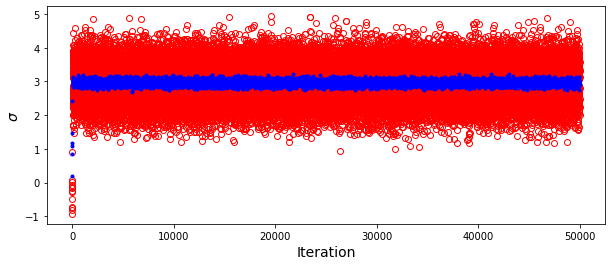

In [85]:
# Plot results
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rejected[:, 2], rejected[:, 1], 'o', markerfacecolor='none', markeredgecolor='r')
ax.plot(accepted[:, 2], accepted[:, 1], '.b')
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
plt.show()

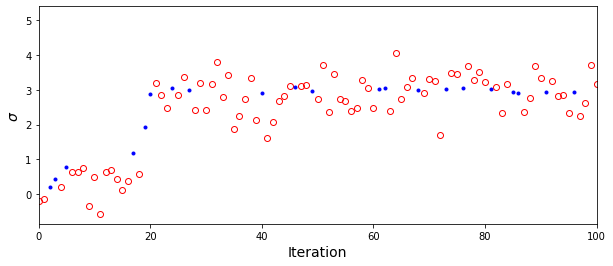

In [80]:
# Plot results
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rejected[:, 2], rejected[:, 1], 'o', markerfacecolor='none', markeredgecolor='r')
ax.plot(accepted[:, 2], accepted[:, 1], '.b')
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_xlim([0, 100])
plt.show()